***
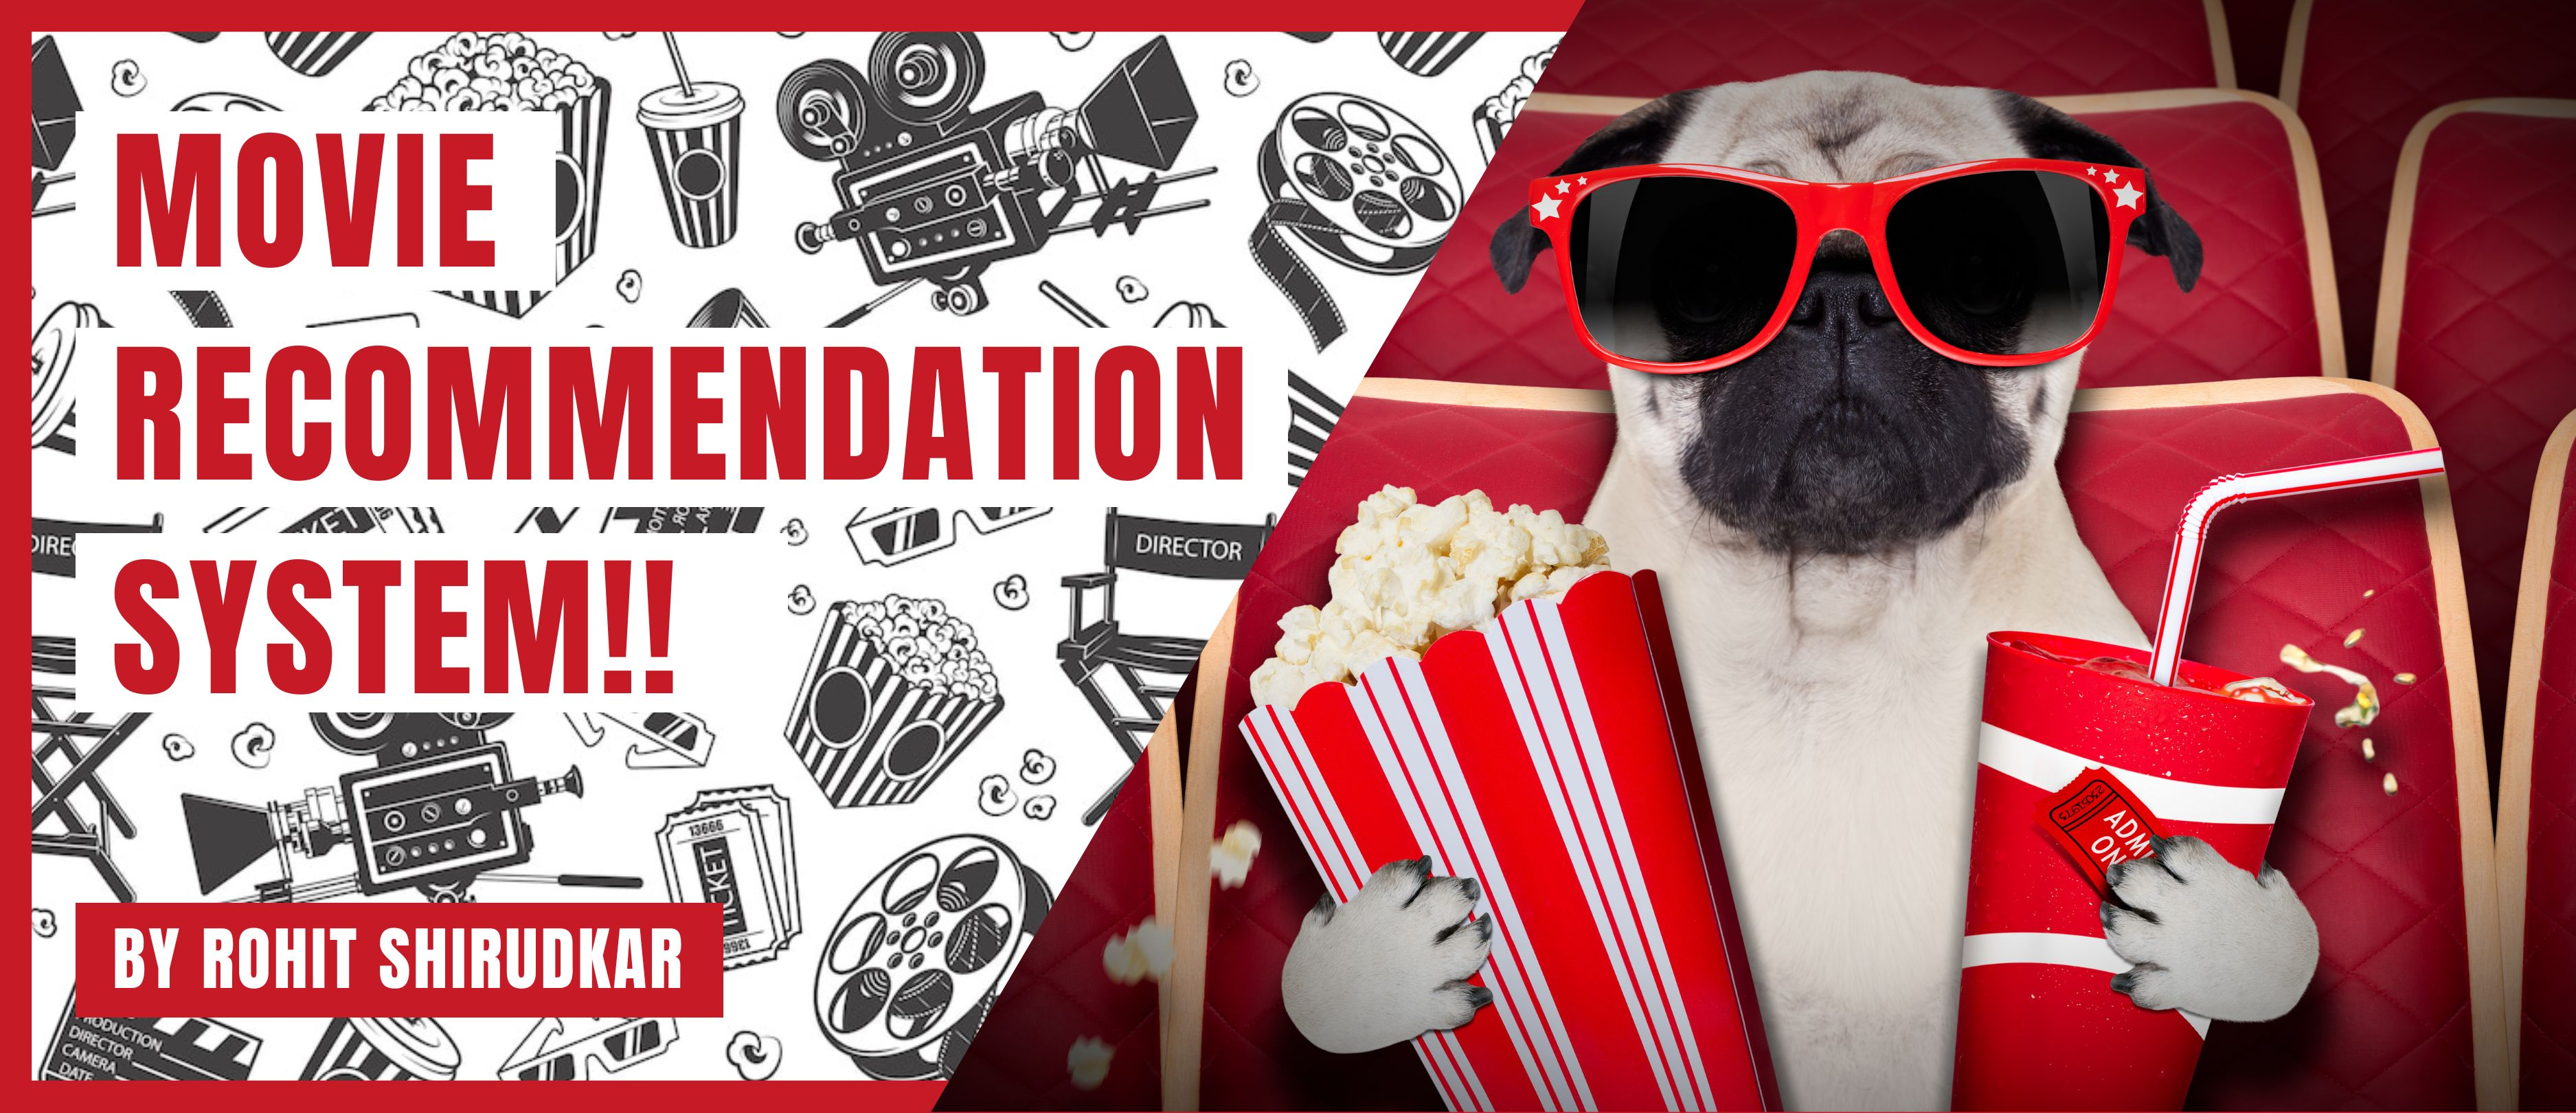

A recommender system aims to suggest relevant content or products to users that might be liked or purchased by them. It helps to find items that the user is looking for — and they don’t even realize it until the recommendation is displayed. Different strategies have to be applied for different clients and they are determined by available data
***

### There are two main techniques used in recommendation system, known as content-based filtering and collaborative filtering

### Content Based :
    Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback.For example, if user A watched two horror movies, another horror movie will be proposed to him.
### Collaborative Filtering :
    To address some of the limitations of content-based filtering, collaborative filtering uses similarities between users and items simultaneously to provide recommendations. Collaborative filtering models can recommend an item to user A based on the interests of a similar user B. Main advantage is that they learn users’ embeddings automatically, without the need for hand-engineering.
    
***

# <p style="background-color:#C71A27;font-family:verdana;color:white;text-align:center;letter-spacing:0.5px;font-size:100%;padding: 10px"> Importing Libraries & Datasets </p>

In [ ]:
import pandas as pd # Python library for data analysis and data frame
import numpy as np # Numerical Python library for linear algebra and computations
pd.set_option('display.max_columns', None) # code to display all columns

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# libraries for text processing
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# to display images
from skimage import io

# to save the required files
import pickle

import warnings
warnings.filterwarnings('ignore') # To prevent kernel from showing any warning

In [ ]:
df = pd.read_csv('../input/millions-of-movies/movies.csv')

# <p style="background-color:#C71A27;font-family:verdana;color:white;text-align:center;letter-spacing:0.5px;font-size:100%;padding: 10px"> Initial Analysis </p>

Understand The Data 🧠

In [ ]:
# How does the data look like?
df.head()

In [ ]:
#How big is data?
df.shape

In [ ]:
# What is the data type of cols?
df.info()

In [ ]:
# Are there any missing values?
df.isnull().sum()

In [ ]:
# Are there duplicate values?
df.duplicated().sum()

<div style="color:white;
           display:fill;
           background-color:#C71A27;
           padding: 10px;
           font-family:Verdana;
           letter-spacing:0.5px">
    <h3 style="color:white;padding-left:20px"><b>Observations 👀</b></h3>
       <p style="color:white;font-size:110%;padding-left:50px">
           1. There are more than 7 lakh rows and 20 columns <br>
           2. Data consists of 6 numeric columns and 14 object/string columns <br>
           3. There are many columns with lots of missing valuest <br>
           4. There are duplicate values present in data <br>
        </p>
    </div>

# <p style="background-color:#C71A27;font-family:verdana;color:white;text-align:center;letter-spacing:0.5px;font-size:100%;padding: 10px"> Preprocessing </p>

In [ ]:
# lets get rid of the duplicate values
df.drop_duplicates(inplace=True)

Let's check if there are any movies with same title

In [ ]:
df['title'].duplicated().sum()

Wow! there are 168580 movies with same title. Now these might be duplicate movies but there's possibility that some might be different movies with same title  
Thats why Let's check if there are any movies with same title and same release date

In [ ]:
df[['title','release_date']].duplicated().sum()

In [ ]:
# lets get rid of the duplicate movies
df.drop_duplicates(subset=['title','release_date'], inplace=True)

In [ ]:
df.shape

Now we have 6 lakh movies but most of the movies have 0 vote count. so we will consider only those movies which have at least more than 20 vote counts.

In [ ]:
# filtering the movies
df1 = df[df.vote_count >= 20].reset_index()

In [ ]:
df1.isnull().sum()

In [ ]:
# Replace the Nan with ''
df1.fillna('', inplace=True)

We are making content based recommendation system and genres , overview are very important to find similar movies. So i will delete movies which don't have genres and overview.

In [ ]:
# finding index with '' genres and overview
index = df1[(df1['genres']=='') & (df1['overview']=='')].index

In [ ]:
# droping those index
df1.drop(index, inplace=True)

* genres, keywords and credits are seperated by '-'
* So replacing that with space
* and from credits only extracting first values words

In [ ]:
df1['genres'] = df1['genres'].apply(lambda x: ' '.join(x.split('-')))
df1['keywords'] = df1['keywords'].apply(lambda x: ' '.join(x.split('-')))
df1['credits'] = df1['credits'].apply(lambda x: ' '.join(x.replace(' ', '').split('-')[:5]))

# <p style="background-color:#C71A27;font-family:verdana;color:white;text-align:center;letter-spacing:0.5px;font-size:100%;padding: 10px"> Creating Tags </p>

Lets create a column with all the important columns which describe a movie, so we can create tags out of it

In [ ]:
df1['tags'] = df1['overview'] +' '+ df1['genres'] +' '+ df1['keywords'] +' '+ df1['credits'] +' '+ df1['original_language']

In [ ]:
df1.tags[0]

Let's apply stemming on tags column

<div class="alert alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes.
</div>

In [ ]:
stemmer = SnowballStemmer("english")
def stem(text):
    y = []
    
    for i in text.split():
        y.append(stemmer.stem(i))
        
    return ' '.join(y)

df1['tags'] = df1['tags'].apply(stem)

In [ ]:
# Removing punctuation 
df1['tags'] = df1['tags'].str.replace('[^\w\s]','')

<div class="alert alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp; TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.
</div>


In [ ]:
tfidf = TfidfVectorizer(stop_words='english')

In [ ]:
tfidf_matrix = tfidf.fit_transform(df1['tags'])

In [ ]:
df1.tags[0]

# <p style="background-color:#C71A27;font-family:verdana;color:white;text-align:center;letter-spacing:0.5px;font-size:100%;padding: 10px"> Recommendation System </p>

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title):
    # Get the index of the movie that matches the title
    idx = df1.index[df1['title'] == title][0]
    # show given movie poster
    try:
        a = io.imread(f'https://image.tmdb.org/t/p/w500/{df1.loc[idx, "poster_path"]}')
        plt.imshow(a)
        plt.axis('off')
        plt.title(title)
        plt.show()
    except:pass
    
    print('Recommendations\n')


    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(
        cosine_similarity(
            tfidf_matrix,
            tfidf_matrix[idx])))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:10]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    result = df1.iloc[movie_indices]
    
    # show reco. movie posters
    fig, ax = plt.subplots(2, 4, figsize=(15,15))
    ax=ax.flatten()
    for i, j in enumerate(result.poster_path):
        try:
            ax[i].axis('off')
            ax[i].set_title(result.iloc[i].title)
            a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
            ax[i].imshow(a)
        except: pass
    fig.tight_layout()
    fig.show()

In [ ]:
get_recommendations("The Matrix")

In [ ]:
pickle.dump(df1,open('movie_list.pkl','wb'))
pickle.dump(tfidf_matrix,open('tfidf_matrix.pkl','wb'))

# <p style="background-color:#C71A27;font-family:verdana;color:white;text-align:center;letter-spacing:0.5px;font-size:100%;padding: 10px"> Deployment </p>

In [ ]:
# Install streamlit 
# NB : If any error occurs during installation process , run it again
!pip install -q streamlit
!npm install -g localtunnel -U

* To deploy any file, it should be in .py format
* Make a .py file and Put code for front and backhand inside .py file
* %%writefile command will convert all the code within this cell into .py file

In [ ]:
%%writefile movie_recommendation_app.py

import pickle
import streamlit as st
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image

@st.cache
def get_recommendation(title):
    idx = df1.index[df1['title'] == title][0]
    poster = f'https://image.tmdb.org/t/p/w500/{df1.loc[idx, "poster_path"]}'

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(
        cosine_similarity(
            tfidf_matrix,
            tfidf_matrix[idx])))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:13]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    result = df1.iloc[movie_indices]

    recommended_movie_names = []
    recommended_movie_posters = []
    recommended_movie_overview = []

    for i, j in enumerate(result.poster_path):
        recommended_movie_names.append(result.iloc[i].title)
        recommended_movie_posters.append(f'https://image.tmdb.org/t/p/w500/{j}')
        recommended_movie_overview.append(result.iloc[i].overview)
    return poster, recommended_movie_names, recommended_movie_posters, recommended_movie_overview


image = Image.open('Movie recommender system.jpg')
st.image(image)

st.markdown('You might have wondered sometime or at some point that how do platforms like Netflix or AmazonPrime Video are able to recommend us TV shows or movies, what kind of an algorithm do these websites use to recommend us movies. Well as complicated or difficult as it might seem this is simply just a mixture of some machine learning algorithms with some Natural Language Processing. ')
st.markdown('There are two main techniques used in recommendation system, known as content-based filtering and collaborative filtering')
st.markdown('For this project I have used Content Based Recommendation System, It uses attributes such as genre, director, description, actors, etc. for movies, to make suggestions for the users. The intuition behind this sort of recommendation system is that if a user liked a particular movie or show, he/she might like a movie or a show similar to it.')

df1 = pickle.load(open('movie_list.pkl ', 'rb'))
tfidf_matrix = pickle.load(open('tfidf_matrix.pkl ', 'rb'))

movies_list = df1['title'].values
selected_movie = st.selectbox('Type and Choose The Movie',movies_list)

if st.button('Show Recommendation'):
    poster,recommended_movie_names,recommended_movie_posters,recommended_movie_overview = get_recommendation(selected_movie)
    st.image(poster,width=160)
    col1, col2, col3, col4 = st.columns(4)
    with col1:
        st.image(recommended_movie_posters[0])
        st.markdown(recommended_movie_names[0])
        with st.expander("OverView"):
            st.write(recommended_movie_overview[0])

        st.image(recommended_movie_posters[4])
        st.markdown(recommended_movie_names[4])
        with st.expander("OverView"):
            st.write(recommended_movie_overview[4])

        st.image(recommended_movie_posters[8])
        st.markdown(recommended_movie_names[8])
        with st.expander("OverView"):
            st.write(recommended_movie_overview[8])

    with col2:
        st.image(recommended_movie_posters[1])
        st.markdown(recommended_movie_names[1])
        with st.expander("OverView"):
            st.write(recommended_movie_overview[1])

        st.image(recommended_movie_posters[5])
        st.markdown(recommended_movie_names[5])
        with st.expander("OverView"):
            st.write(recommended_movie_overview[5])

        st.image(recommended_movie_posters[9])
        st.markdown(recommended_movie_names[9])
        with st.expander("OverView"):
            st.write(recommended_movie_overview[9])

    with col3:
        st.image(recommended_movie_posters[2])
        st.markdown(recommended_movie_names[2])
        with st.expander("OverView"):
            st.write(recommended_movie_overview[2])

        st.image(recommended_movie_posters[6])
        st.markdown(recommended_movie_names[6])
        with st.expander("OverView"):
            st.write(recommended_movie_overview[6])

        st.image(recommended_movie_posters[10])
        st.markdown(recommended_movie_names[10])
        with st.expander("OverView"):
            st.write(recommended_movie_overview[10])

    with col4:
        st.image(recommended_movie_posters[3])
        st.markdown(recommended_movie_names[3])
        with st.expander("OverView"):
            st.write(recommended_movie_overview[3])

        st.image(recommended_movie_posters[7])
        st.markdown(recommended_movie_names[7])
        with st.expander("OverView"):
            st.write(recommended_movie_overview[7])

        st.image(recommended_movie_posters[11])
        st.markdown(recommended_movie_names[11])
        with st.expander("OverView"):
            st.write(recommended_movie_overview[11])


When you'll run following cell, it will display a UI in your terminal with public URL of your tunnel and other status and metrics information about connections made over your tunnel

In [ ]:
!streamlit run movie_recommendation_app.py & npx localtunnel --port 8501 

Sometimes it don't work in kaggle. if not working use Google Colab with same code and you'll get a link for the webapp

# <p style="background-color:#C71A27;font-family:verdana;color:white;text-align:center;letter-spacing:0.5px;font-size:100%;padding: 10px"> If You Liked The NoteBook, Please Upvote✌ </p>